In [61]:
import os
import glob
import pandas as pd
import yfinance as yf
from datetime import datetime

In [20]:
companies = open("companies.txt").read().splitlines()

In [30]:
strings = ["cybersecurity", "cyber security", "cyber-security"]
date_after = "2000-01-01"
filings = ['8-K', '10-K']

df = pd.DataFrame(columns=['Company', 'Date', 'Word_count', 'Filing', 'Path'])

for company in companies:

    for filing in filings:

        paths = glob.glob(f'sec-edgar-filings/{company}/{filing}/*/*.txt')

        for path in paths:
            file = open(path, "r")
            string_count = 0

            # get date of file based on text at beginning of line
            for line in file:
                if "<SEC-DOCUMENT>" in line:
                    date = line[-9:-1]
                    break
            
            # counts if line contains any of the contents of strings
            for line in file:
                if any(string in line.lower() for string in strings):
                    string_count += 1
            
            df.loc[len(df.index)] = [company, date, string_count, filing, path]
            file.close()

# convert date to datetime and sort in order
df['Date'] = pd.to_datetime(df['Date'],format='%Y%m%d')
df = df.sort_values(by='Date')

# Creates columns for 8-K & 10-K Counts
for filing in filings:  
    df[filing] = df.loc[(df['Filing'] == filing)]['Word_count']

In [94]:
# Saves contents to CSV
terms = '_'.join(string for string in strings)
df.to_csv(f'word-count/{terms}_{datetime.now()}.csv', index=False) 

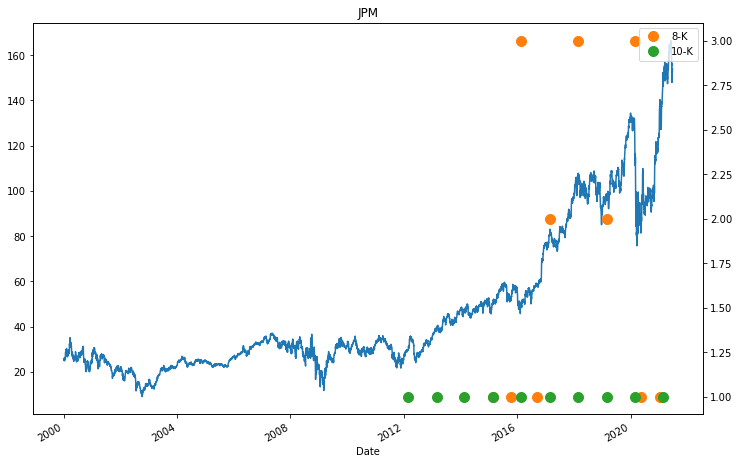

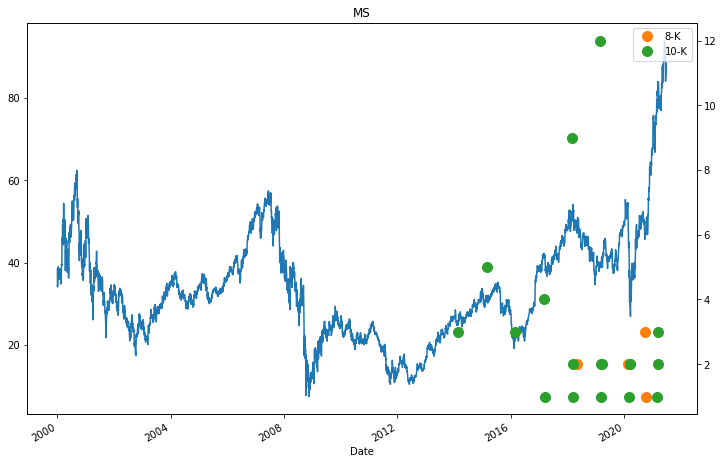

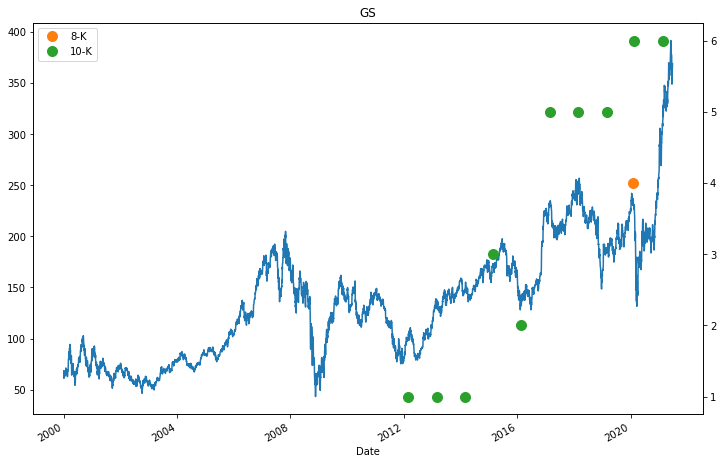

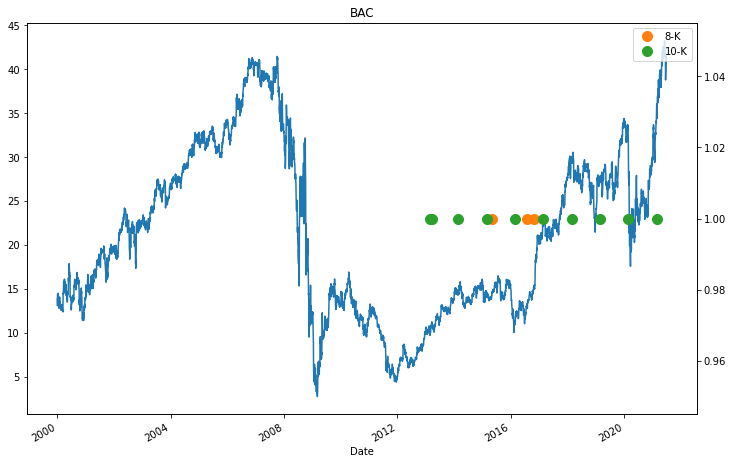

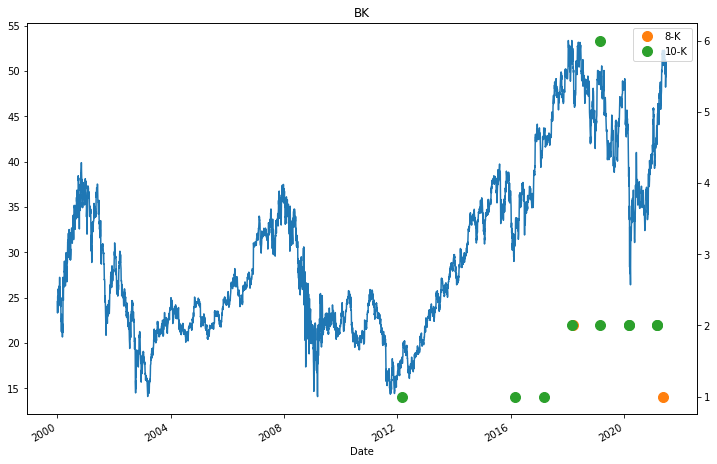

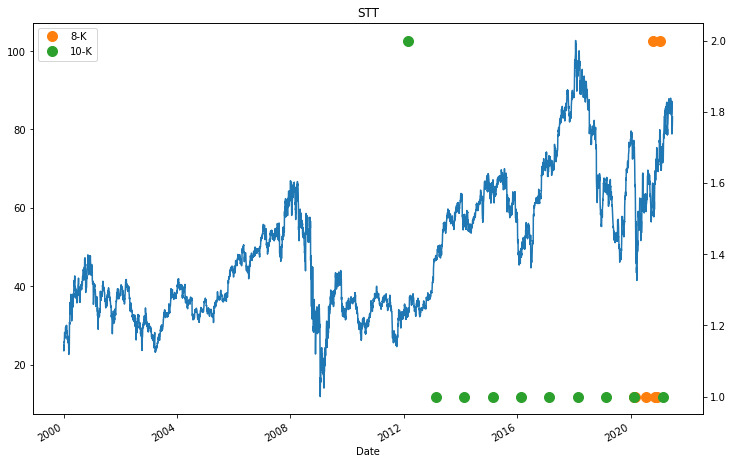

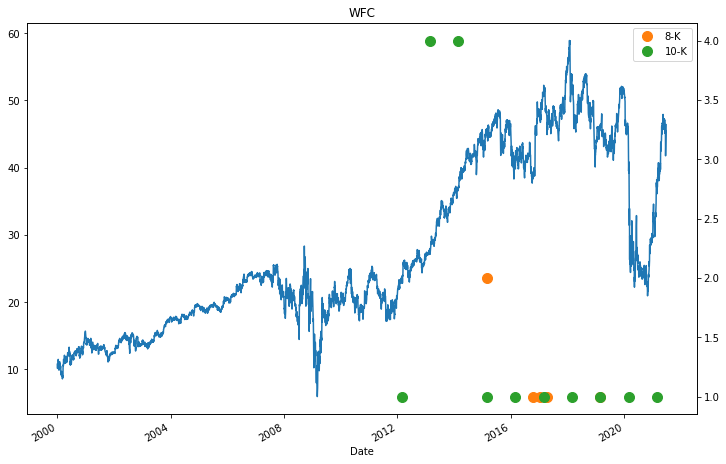

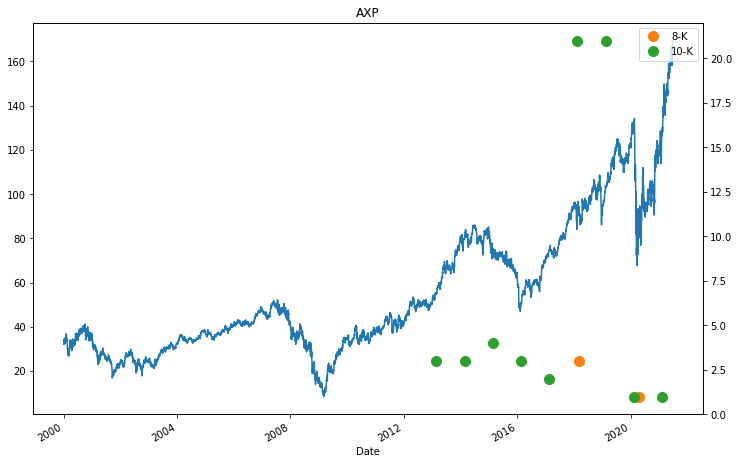

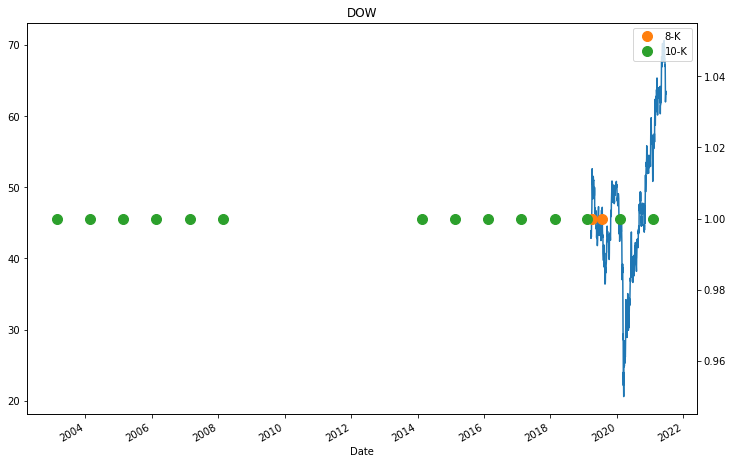

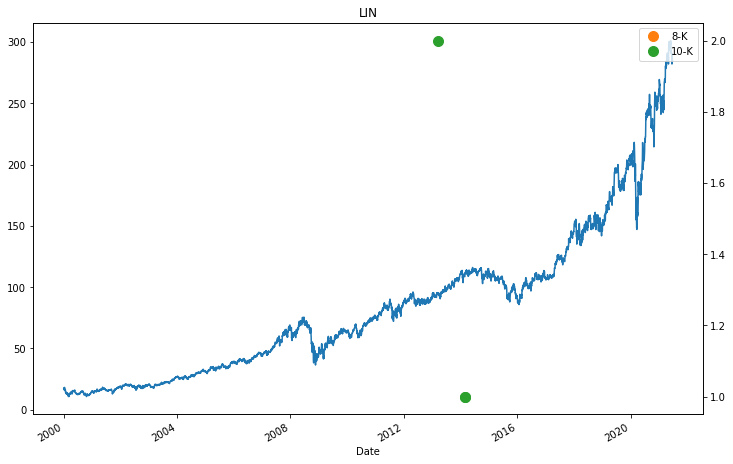

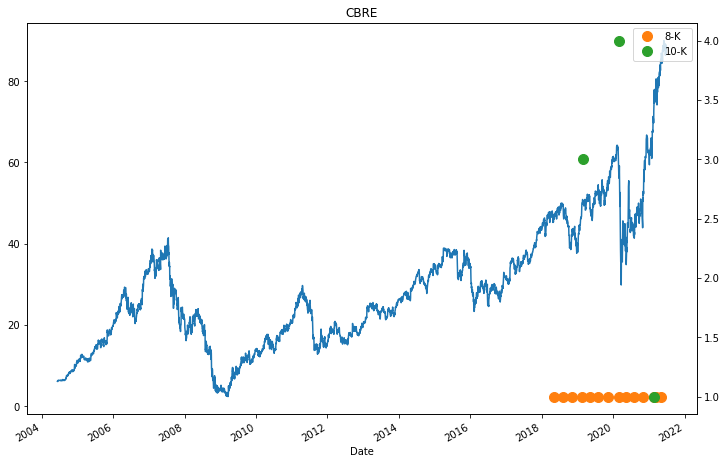

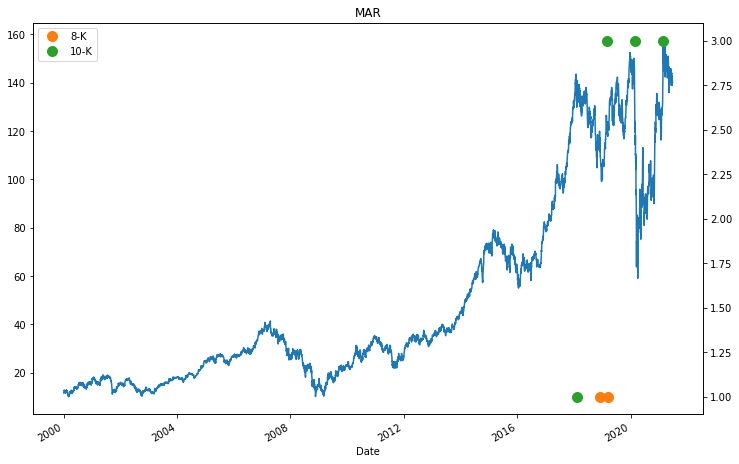

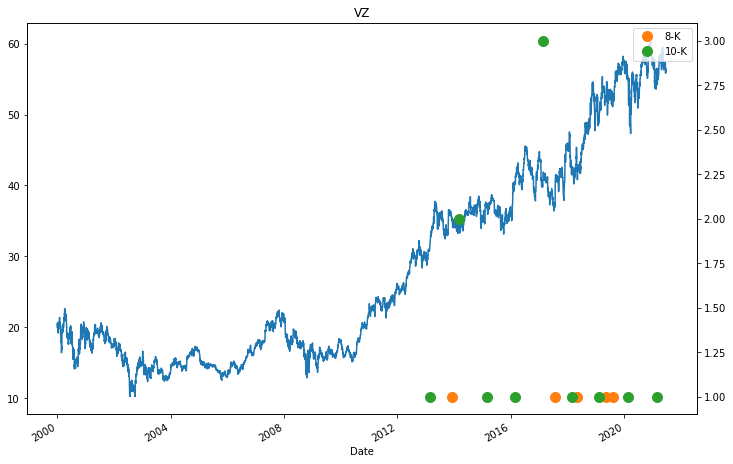

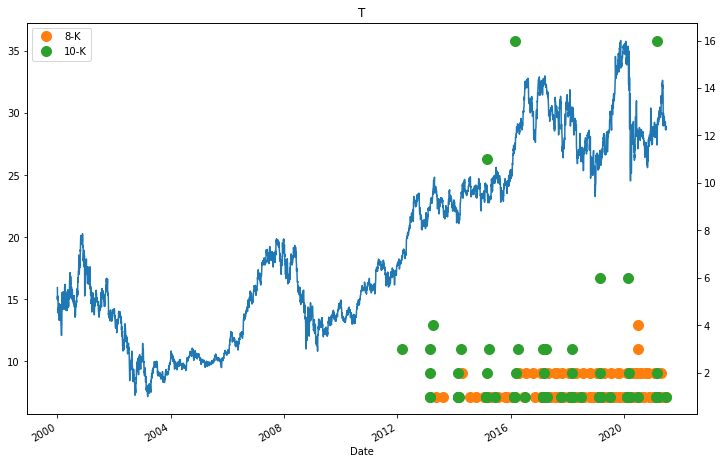

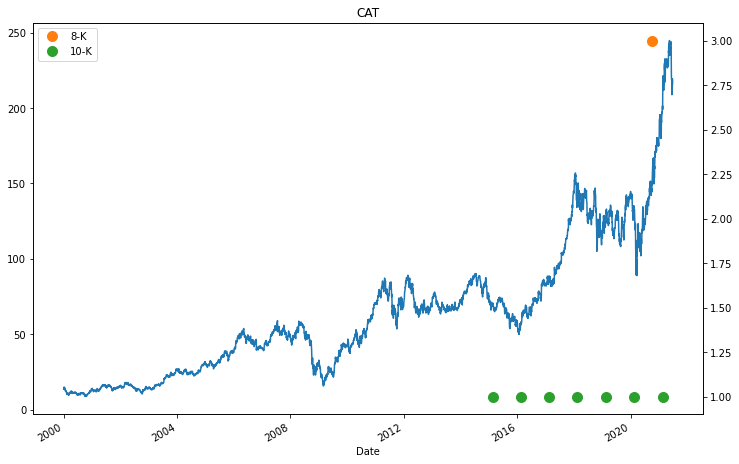

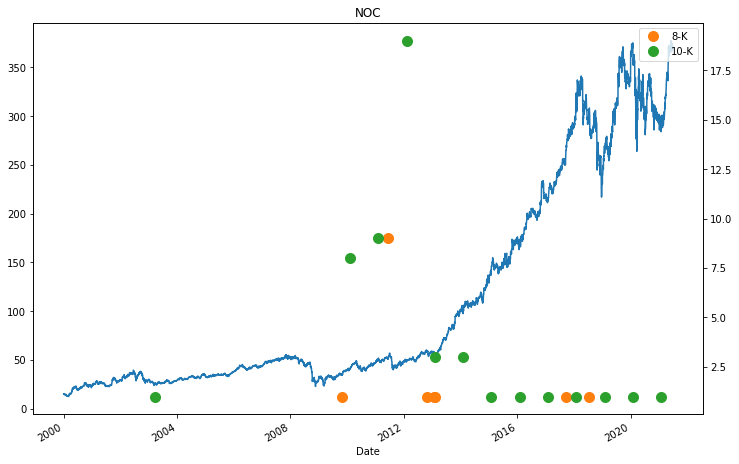

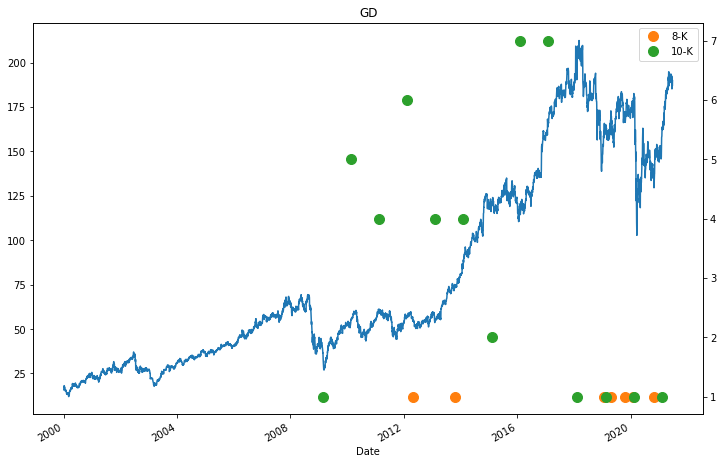

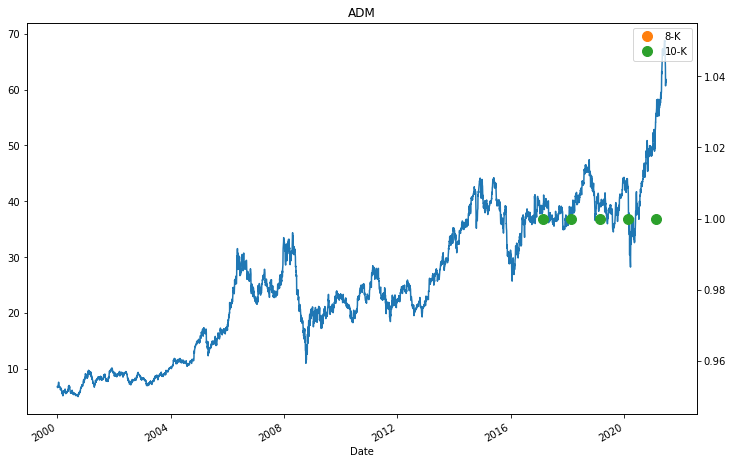

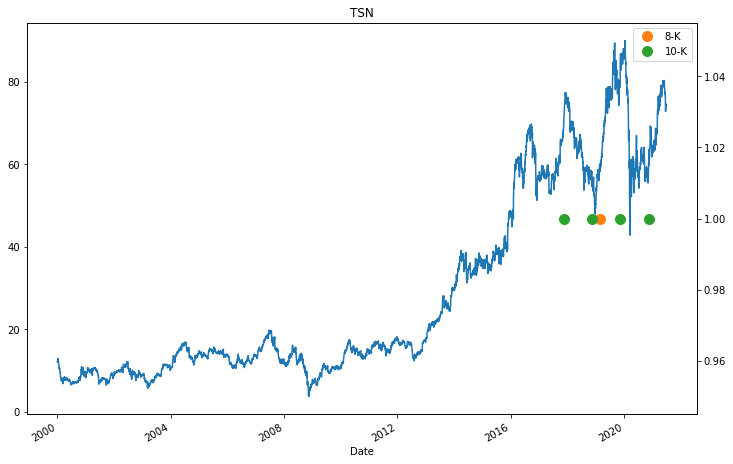

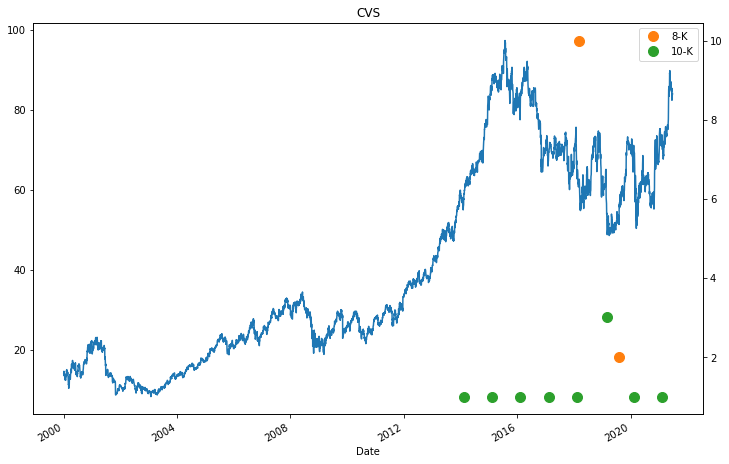

NHYDY no data downloaded, skipping...


In [93]:
for company in companies:

    # Check if previously downloaded reports and skips if so
    check_path = glob.glob(f'sec-edgar-filings/{company}/*/*/*')
    if check_path == []:
        print(f"{company} no data downloaded, skipping...")
        continue

    # Create dataframes for each type of filing
    comp_df = df.loc[(df['Company'] == company)].set_index('Date')

    # Get stock price of company and append to df and sort by date
    ticker = yf.Ticker(company)
    stock_df = ticker.history(start=date_after)
    comp_df = comp_df.append(stock_df)
    comp_df = comp_df.sort_values(by='Date')

    # Plot out companies stock prices vs counts of mention of keywords
    plt.figure()
    comp_df['Close'].dropna().plot(title=company, figsize=(12,8))
    for filing in filings:
        comp_df[filing].loc[(comp_df[filing] != 0)].dropna().astype(float).plot(style='o', markersize=10, secondary_y=True)
    plt.legend(loc='best')
    plt.show()